#**Thai sentiment analysis about education in Thailand on Twitter.** 🙂😐☹️

# **Model & Validation process** ⚙️🔨

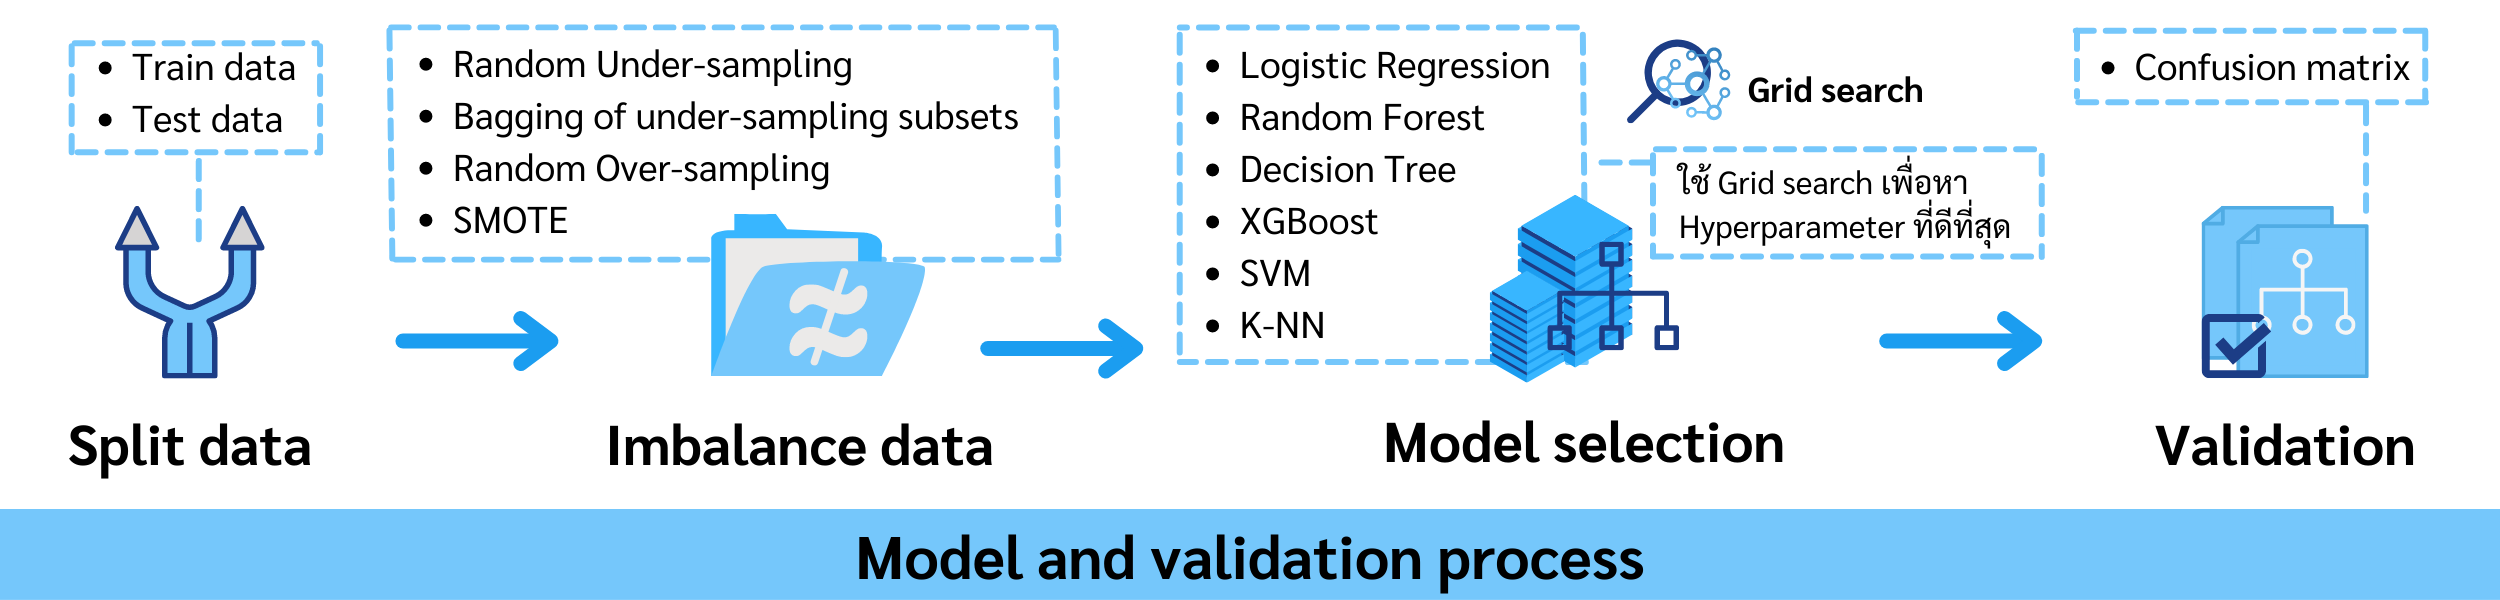


### การนำเข้าแพ็คเกจที่จำเป็น

In [ ]:
!pip install pythainlp
!pip install stop-words
!pip install stopwords
!pip install python-crfsuite

import pandas as pd
import tweepy as tw
import numpy as np 

import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.corpus import words
from stop_words import get_stop_words

# from nltk.tokenize import word_tokenize
import pythainlp
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus import thai_stopwords

from sklearn.model_selection import train_test_split

import seaborn as sn
import matplotlib.pyplot as plt
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import pickle as p
import plotly
import plotly.graph_objs as go

import urllib
import requests

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

## Load pickle files

In [ ]:
import pickle
# load the TFIDF from disk
TFIDF = pickle.load(open('TFIDF.pkl', 'rb'))

# load the label from disk
label = pickle.load(open('label.pkl', 'rb'))

# Split data

In [ ]:
from sklearn.model_selection import train_test_split # ทำการแบ่งข้อมูลฝึกสอนและทดสอบ
X = TFIDF
y = label
# ข้อมูลฝึกสอนและทดสอบ
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4267, 1000), (4267,), (1830, 1000), (1830,))

# Imbalance data

### Random Oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler

#ros = RandomOverSampler(sampling_strategy=1) # Float
ros = RandomOverSampler(sampling_strategy="not majority") # String
x_train_ros, y_train_ros = ros.fit_resample(x_train, y_train)

In [ ]:
df_ros = pd.DataFrame(y_train_ros)
df_ros.value_counts()

category
-1          2322
0           2322
1           2322
dtype: int64

# Model and validation



##Grid search    
[CS51_Grid search.ipynb]

##Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
Log_Reg = LogisticRegression(random_state=0,C= 2, max_iter=100, penalty= 'l2',solver= 'liblinear')

In [ ]:
Log_Reg.fit(x_train_ros,df_ros)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=2, random_state=0, solver='liblinear')

In [ ]:
prediction_tfidf = Log_Reg.predict_proba(x_test)
prediction_tfidf  = np.argmax(prediction_tfidf ,axis=1)
prediction_int = prediction_tfidf -1

In [ ]:
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
#prediction_int = prediction_tfidf[:,1]>=0.3
from sklearn.metrics import f1_score
prediction_int = prediction_int.astype(np.int)
prediction_int

# calculating f1 score
log_tfidf = f1_score(y_test.apply(pd.to_numeric), prediction_int, average='weighted')

log_tfidf

0.6583953411751106

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test.apply(pd.to_numeric), prediction_int))

              precision    recall  f1-score   support

          -1       0.78      0.71      0.74      1023
           0       0.60      0.56      0.58       722
           1       0.20      0.53      0.29        85

    accuracy                           0.64      1830
   macro avg       0.53      0.60      0.54      1830
weighted avg       0.68      0.64      0.66      1830



Text(23.999999999999996, 0.5, 'Actual')

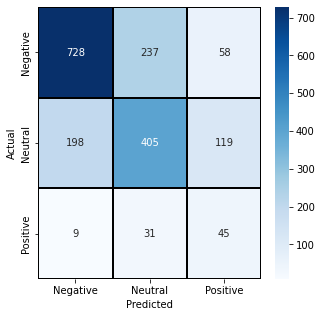

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test.apply(pd.to_numeric), prediction_int)
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = ['Negative','Neutral','Positive'], 
            yticklabels = ['Negative','Neutral','Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MaxAbsScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification, load_breast_cancer

smote = SMOTE(random_state = 11)
X_train, y_train = smote.fit_resample(x_train_ros,df_ros)
pipeline = Pipeline(steps = [['scaler', MaxAbsScaler()],
                             ['classifier', LogisticRegression(random_state=11,
                                                               max_iter=1000)]])

stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)
    
param_grid = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,                       
                           cv=stratified_kfold,
                           n_jobs=-1)



grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(x_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Cross-validation score: 0.7563881711168533
Test score: 0.6366120218579235


##XGBoost

In [1]:
from xgboost import XGBClassifier

In [ ]:
model_tfidf = XGBClassifier(random_state=29,learning_rate=0.7,colsample_bytree=1.0, gamma=2, max_depth=5,
              objective='multi:softprob', subsample=0.6)

In [ ]:
model_tfidf.fit(x_train_ros,df_ros)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(colsample_bytree=1.0, gamma=2, learning_rate=0.7, max_depth=5,
              objective='multi:softprob', random_state=29, subsample=0.6)

In [ ]:
xgb_tfidf=model_tfidf.predict_proba(x_test)
xgb_tfidf = np.argmax(xgb_tfidf,axis=1)
xgb_tfidf = xgb_tfidf-1
xgb_tfidf 

array([ 0,  0,  0, ..., -1, -1,  0])

In [ ]:
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
#xgb_tfidf=xgb_tfidf[:,1]>=0.3

# converting the results to integer type
xgb_int_tfidf=xgb_tfidf.astype(np.int)

# calculating f1 score
score=f1_score(y_test.apply(pd.to_numeric),xgb_int_tfidf, average='weighted')

score

0.6434399366738399

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test.apply(pd.to_numeric), xgb_int_tfidf))

              precision    recall  f1-score   support

          -1       0.74      0.72      0.73      1023
           0       0.57      0.57      0.57       722
           1       0.22      0.29      0.25        85

    accuracy                           0.64      1830
   macro avg       0.51      0.53      0.52      1830
weighted avg       0.65      0.64      0.64      1830



Text(23.999999999999996, 0.5, 'Actual')

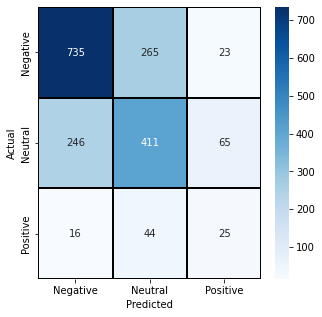

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test.apply(pd.to_numeric), xgb_int_tfidf)
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = ['Negative','Neutral','Positive'], 
            yticklabels = ['Negative','Neutral','Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MaxAbsScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification, load_breast_cancer

smote = SMOTE(random_state = 11)
X_train, y_train = smote.fit_resample(x_train_ros,df_ros)
pipeline = Pipeline(steps = [['scaler', MaxAbsScaler()],
                             ['classifier', XGBClassifier(random_state=11,
                                                               max_iter=1000)]])

stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)
    
param_grid = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,                       
                           cv=stratified_kfold,
                           n_jobs=-1)



grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(x_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Cross-validation score: 0.6896353718059145
Test score: 0.5497267759562842


##Decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dct = DecisionTreeClassifier(criterion='entropy',max_depth=20, min_samples_leaf=20, random_state=42)

In [ ]:
dct.fit(x_train_ros,df_ros)

DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=20,
                       random_state=42)

In [ ]:
dct_tfidf = dct.predict_proba(x_test)
dct_tfidf = np.argmax(dct_tfidf ,axis=1)
dct_tfidf = dct_tfidf -1
dct_tfidf

array([ 1,  1,  0, ..., -1, -1,  1])

In [ ]:
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
#dct_tfidf=dct_tfidf[:,1]>=0.3

# converting the results to integer type
dct_int_tfidf=dct_tfidf.astype(np.int)

# calculating f1 score
dct_score_tfidf=f1_score(y_test.apply(pd.to_numeric),dct_int_tfidf, average='weighted')

dct_score_tfidf

0.47869720572176067

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test.apply(pd.to_numeric), dct_int_tfidf))

              precision    recall  f1-score   support

          -1       0.73      0.52      0.61      1023
           0       0.44      0.27      0.34       722
           1       0.09      0.66      0.15        85

    accuracy                           0.43      1830
   macro avg       0.42      0.48      0.36      1830
weighted avg       0.58      0.43      0.48      1830



Text(23.999999999999996, 0.5, 'Actual')

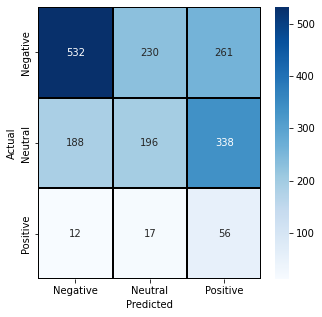

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test.apply(pd.to_numeric), dct_int_tfidf)
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = ['Negative','Neutral','Positive'], 
            yticklabels = ['Negative','Neutral','Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")


##Random Forest

The sklearn.ensemble module contains the RandomForestClassifier class that can be used to train the machine learning model using the random forest algorithm. To do so, we need to call the fit method on the RandomForestClassifier class and pass it our training features and labels, as parameters. Look at the following script:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators=200, random_state=0,max_depth=6, max_leaf_nodes=5, max_samples=0.8,
                       min_samples_leaf=3,min_samples_split= 2)
text_classifier.fit(x_train_ros,df_ros)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestClassifier(max_depth=6, max_leaf_nodes=5, max_samples=0.8,
                       min_samples_leaf=3, n_estimators=200, random_state=0)

###Making Predictions and Evaluating the Model
เมื่อโมเดลได้รับการฝึกอบรมแล้ว ขั้นตอนสุดท้ายคือการคาดการณ์เกี่ยวกับโมเดล ในการทำเช่นนั้น เราต้องเรียกpredictmethod บน object ของRandomForestClassifierclass ที่เราใช้ในการฝึก

In [ ]:
predictions = text_classifier.predict(x_test)

สุดท้ายในการประเมินประสิทธิภาพการทำงานของโมเดลการเรียนรู้ที่เราสามารถใช้ตัวชี้วัดการจัดหมวดหมู่เช่น Confusion Metrix ,  F1 measure, accuracy ฯลฯ
ในการค้นหาค่าของตัวชี้วัดเหล่านี้ เราสามารถใช้classification_report, confusion_matrix, และaccuracy_score utilities จาก sklearn.metricsไลบรารี

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print('Accuracy :',accuracy_score(y_test, predictions))

[[636 249 138]
 [176 295 251]
 [ 11  22  52]]
              precision    recall  f1-score   support

          -1       0.77      0.62      0.69      1023
           0       0.52      0.41      0.46       722
           1       0.12      0.61      0.20        85

    accuracy                           0.54      1830
   macro avg       0.47      0.55      0.45      1830
weighted avg       0.64      0.54      0.58      1830

Accuracy : 0.5371584699453552


Text(23.999999999999996, 0.5, 'Actual')

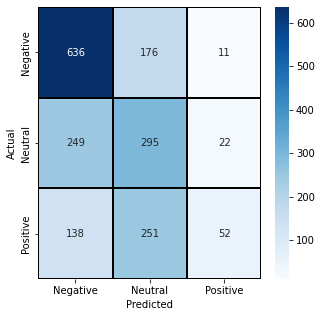

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(predictions,y_test)
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = ['Negative','Neutral','Positive'], 
            yticklabels = ['Negative','Neutral','Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")


##K-Nearest Neighbour


##Feature Scaling
Before making any actual predictions, it is always a good practice to scale the features so that all of them can be uniformly evaluated.

(Since the range of values of raw data varies widely, in some machine learning algorithms, objective functions will not work properly without normalization. For example, the majority of classifiers calculate the distance between two points by the Euclidean distance. If one of the features has a broad range of values, the distance will be governed by this particular feature. Therefore, the range of all features should be normalized so that each feature contributes approximately proportionately to the final distance.)
เนื่องจากช่วงของค่าของข้อมูลดิบนั้นแตกต่างกันอย่างมาก ในอัลกอริธึมการเรียนรู้ของเครื่องบางตัว ฟังก์ชันวัตถุประสงค์จะไม่ทำงานอย่างถูกต้องหากไม่มีการทำให้เป็นมาตรฐาน ตัวอย่างเช่น ตัวแยกประเภทส่วนใหญ่คำนวณระยะห่างระหว่างจุดสองจุดด้วยระยะทางแบบยุคลิด หากคุณลักษณะใดค่าหนึ่งมีค่าเป็นช่วงกว้าง ระยะทางจะเป็นไปตามคุณลักษณะเฉพาะนี้ ดังนั้น ช่วงของคุณสมบัติทั้งหมดควรถูกทำให้เป็นมาตรฐาน เพื่อให้แต่ละสถานที่มีส่วนสนับสนุนตามสัดส่วนโดยประมาณกับระยะทางสุดท้าย

The gradient descent algorithm (which is used in neural network training and other machine learning algorithms) also converges faster with normalized features.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
scaler.fit(x_train_ros)

X_train = scaler.transform(x_train_ros)
X_test = scaler.transform(x_test)



###Training and Predictions
การฝึกอัลกอริทึม KNN และคาดการณ์ได้ตรงไปตรงมาอย่างยิ่ง โดยเฉพาะเมื่อใช้ Scikit-Learn

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5,n_jobs=-1, weights='distance',algorithm= 'auto', leaf_size= 30, metric= 'minkowski',p= 2)
classifier.fit(x_train_ros,df_ros)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_jobs=-1, weights='distance')

ขั้นตอนแรกคือการนำเข้าKNeighborsClassifierคลาสจากsklearn.neighborsไลบรารี n_neigboursในบรรทัดที่สองชั้นนี้จะเริ่มต้นได้ด้วยพารามิเตอร์หนึ่งคือ นี่คือค่าของ K โดยพื้นฐานแล้ว ไม่มีค่าในอุดมคติสำหรับ K และค่านี้จะถูกเลือกหลังจากการทดสอบและประเมินผล อย่างไรก็ตาม ในการเริ่มต้น ดูเหมือนว่า 5 จะเป็นค่าที่ใช้บ่อยที่สุดสำหรับอัลกอริทึม KNN

In [ ]:
y_pred = classifier.predict(X_test)

###Evaluating the Algorithm
For evaluating an algorithm, confusion matrix, precision, recall and f1 score are the most commonly used metrics. The confusion_matrix and classification_report methods of the sklearn.metrics can be used to calculate these metrics. 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[538 432  53]
 [248 391  83]
 [ 23  39  23]]
              precision    recall  f1-score   support

          -1       0.67      0.53      0.59      1023
           0       0.45      0.54      0.49       722
           1       0.14      0.27      0.19        85

    accuracy                           0.52      1830
   macro avg       0.42      0.45      0.42      1830
weighted avg       0.56      0.52      0.53      1830



ความแม่นยำโดยรวมของแบบจำลองในข้อมูลการทดสอบอยู่ที่ประมาณ 27% ซึ่งถือว่าค่อนข้างแย่เมื่อพิจารณาว่าเราไม่ได้ทำการแยกคุณลักษณะหรือประมวลผลล่วงหน้ามากนัก

Text(23.999999999999996, 0.5, 'Actual')

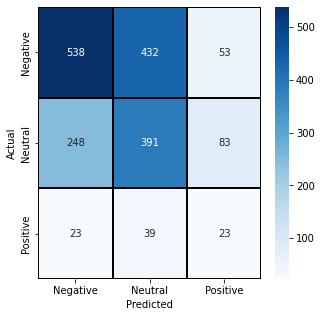

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = ['Negative','Neutral','Positive'], 
            yticklabels = ['Negative','Neutral','Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")


##SVM

###Vectorizing the data

Creating a Linear SVM Model

In [ ]:
import time
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import classification_report
# Perform classification with SVM, kernel=linear
#classifier_linear = svm.SVC(kernel='linear')


In [ ]:
# train the model on train set
#hyperparameter
#C=1, kernel='rbf', gamma=0.01
model = SVC(C=100, gamma=0.001,kernel= 'rbf')
model.fit(x_train_ros,df_ros)
 
# print prediction results
predictions = model.predict(x_test)
print(classification_report(y_test, predictions))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

          -1       0.80      0.61      0.69      1023
           0       0.55      0.63      0.59       722
           1       0.21      0.58      0.31        85

    accuracy                           0.61      1830
   macro avg       0.52      0.60      0.53      1830
weighted avg       0.67      0.61      0.63      1830



Text(23.999999999999996, 0.5, 'Actual')

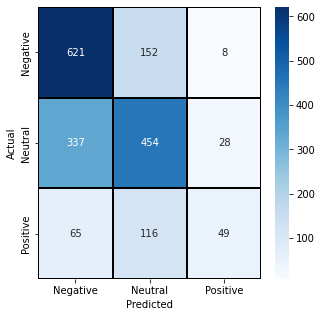

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(predictions,y_test)
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = ['Negative','Neutral','Positive'], 
            yticklabels = ['Negative','Neutral','Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")


##Naive bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [ ]:
MNB = MultinomialNB(alpha=100, fit_prior=True, class_prior=None)
MNB.fit(x_train_ros,df_ros)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB(alpha=100)

In [ ]:
predictions = MNB.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          -1       0.68      0.83      0.75      1023
           0       0.62      0.31      0.41       722
           1       0.24      0.64      0.35        85

    accuracy                           0.62      1830
   macro avg       0.51      0.59      0.50      1830
weighted avg       0.64      0.62      0.60      1830



Text(23.999999999999996, 0.5, 'Actual')

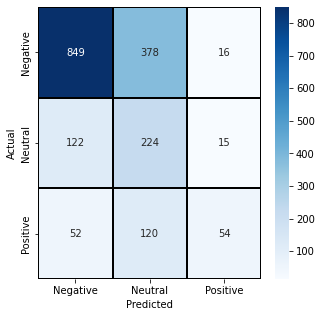

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(predictions,y_test)
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = ['Negative','Neutral','Positive'], 
            yticklabels = ['Negative','Neutral','Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
